# Demo code for using augmentation.py

In [1]:
import pandas as pd
import numpy as np
import os
import re
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
from imgaug import BoundingBoxesOnImage
from skimage.io import imsave
from skimage import img_as_ubyte
from augmentation import *

In [2]:
# Helper function to draw box
def draw_box(image_path, patient_id, annotation, plot = True):
    """Draw bounding boxes given image path, patient id and annotaion dataframe"""
    image = mpimg.imread(image_path)
    patient_row = annotation.loc[annotation['patient_id'] == patient_id]
    bounding_box_array = patient_row.drop(
                    ["filename", "width", "height", "class", "patient_id"], axis=1
                ).values
    xmin, ymin, xmax, ymax = bounding_box_array[0]
    
    if plot:
        xy = (xmin,ymin) 
        w = xmax - xmin
        h = ymax - ymin
        _, ax = plt.subplots(1)
        ax.imshow(image)
        rect = Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
    
    return bounding_box_array


In [88]:
def return_info(file, folder, image, bounding_box):
    patient_id = file.split('.png')[0][-3:]
    width = image.shape[1]
    height = image.shape[0]
    xmin, ymin, xmax, ymax = bounding_boxes_to_df(bounding_box).values[0]
    return file, folder, patient_id, xmin, ymin, xmax, ymax, width, height

In [90]:
# Iterate to resize image and bounding box

# Define image resizer:
image_resizer = iaa.Resize({"height": 512, "width": 512})

info_list = []

# Fill this DataFrame with image attributes
columns=[
    "filename",
    "class",
    "patient_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "width",
    "height",
]

# iterate over each file
for _, row in annotation_df.iterrows():

    # iterate over each file
    folder = row['class']
    file = row['filename']
    image_path = os.path.join(IMG_DIR, 'Original_Data', folder, file)
    output_image_path = os.path.join(IMG_DIR, 'Resized_Data', folder, file)
    
    # check that input and output directories exist
    assert(os.path.exists(image_path))
    # if the output directory does not exist, create it
    if not os.path.exists(
        os.path.join(IMG_DIR, 'Resized_Data', folder)
    ): 
        os.mkdir(os.path.join(IMG_DIR, 'Resized_Data', folder))

    # get bounding box information
    image = mpimg.imread(image_path)
    bounding_box_array = draw_box(
        image_path,
        row['patient_id'],
        annotation_df,
        plot = False
    )
    bounding_box = BoundingBoxesOnImage.from_xyxy_array(
                    bounding_box_array, shape=image.shape
    )

    # resize image and bounding boxes
    image_resized, bounding_box_resized = image_resizer(
        image = image,
        bounding_boxes = bounding_box
    )
    
    # convert uint16 datatype to float, scaled properly for uint8
    image_resized = image_resized.astype(float) * 255. / image_resized.max()
    # convert from float -> uint8
    image_resized = image_resized.astype(np.uint8)
    # Save new image
    imsave(output_image_path, image_resized)

    # Store information as a dataframe
    # Update the image width and height after augmentation
    info_df = row.drop(
        ["xmin", "ymin", "xmax", "ymax"]
    )
    info_df["width"] = image_resized.shape[1]
    info_df["height"] = image_resized.shape[0]
    info_df["filename"] = file
    # Save information about new bounded box
    values = return_info(file, folder, image_resized, bounding_box_resized)
    info_list.append(values)

# Put everything into a new dataframe
resized_df = pd.DataFrame(info_list, columns=columns)


In [ ]:
resized_df.to_csv("/workspaces/breast-tumor-detection/Preprocessing/resized_annotation_boxes.csv")

In [4]:
resized_df = pd.read_csv('/workspaces/breast-tumor-detection/Preprocessing/resized_annotation_boxes.csv', index_col=0,
                         dtype = {'patient_id':'str'})

In [5]:
resized_df

,filename,class,patient_id,xmin,ymin,xmax,ymax,width,height
0,1-130-BreastMRI038.png,pos,038,370.00000,255.00000,410.00000,291.00000,512,512
1,1-102-BreastMRI003.png,pos,003,82.00000,351.00000,139.00000,412.00000,512,512
2,1-104-BreastMRI223.png,pos,223,364.57144,132.57143,393.14285,157.71428,512,512
3,1-124-BreastMRI060.png,pos,060,364.00000,220.00000,413.00000,271.00000,512,512
4,1-083-BreastMRI215.png,pos,215,370.28570,344.00000,389.71430,361.14285,512,512
...,...,...,...,...,...,...,...,...,...
299,1-089-BreastMRI204.png,pos,204,73.14286,99.42857,84.57143,115.42857,512,512
300,1-072-BreastMRI240.png,pos,240,386.00000,256.00000,414.00000,324.00000,512,512
301,1-107-BreastMRI085.png,pos,085,120.00000,182.85715,154.28572,213.71428,512,512
302,1-090-BreastMRI094.png,pos,094,69.71429,48.00000,130.28572,122.28571,512,512


### Augment the resized data

In [6]:
augmentations_df = image_aug(
    df = resized_df,
    images_path='/workspaces/breast-tumor-detection/Data/Resized_Data/',
    aug_images_path='/workspaces/breast-tumor-detection/Data/Augmented_Data',
    augmentor= image_augmentations
)

In [7]:
augmentations_df

,filename,class,patient_id,xmin,ymin,xmax,ymax,width,height
0,Aug-1BreastMRI038.png,pos,038,98.513611,209.797409,147.325317,255.960907,512,512
1,Aug-1BreastMRI003.png,pos,003,373.000000,351.000000,430.000000,412.000000,512,512
2,Aug-1BreastMRI223.png,pos,223,254.982544,24.299423,283.553955,49.442276,512,512
3,Aug-1BreastMRI060.png,pos,060,106.294952,159.713135,171.707062,226.148239,512,512
4,Aug-1BreastMRI215.png,pos,215,365.252350,340.124329,383.825287,356.512177,512,512
...,...,...,...,...,...,...,...,...,...
885,Aug-3BreastMRI204.png,pos,204,73.142860,99.428574,84.571426,115.428574,512,512
886,Aug-3BreastMRI240.png,pos,240,358.536774,141.971069,429.697357,215.813339,512,512
887,Aug-3BreastMRI085.png,pos,085,76.123024,159.259445,121.470169,200.071854,512,512
888,Aug-3BreastMRI094.png,pos,094,341.289978,172.189178,384.012726,219.541824,512,512


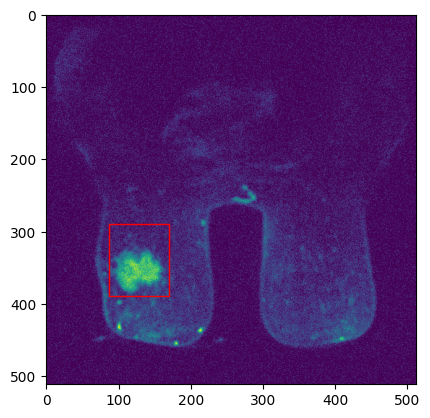

array([[ 87.      , 290.      , 170.      , 389.      ],
       [322.48566 , 282.28503 , 386.65204 , 358.82083 ],
       [ 56.033607, 434.8542  , 139.0336  , 512.      ]], dtype=float32)

In [9]:
draw_box(
    os.path.join('/workspaces/breast-tumor-detection/Data/Augmented_Data/pos/Augmentation_1/', augmentations_df.loc[16,'filename']),
    patient_id=augmentations_df.loc[16,'patient_id'],
    annotation=augmentations_df
)